In [1]:
import pandas as pd
import numpy as np

In [2]:
df_cancer = pd.read_csv("pollution_cancer.csv")
df_cancer.head()

,County,Year,Deaths,Crude Rate,Age Adjusted Rate,Days_PM25_fraction,Unhealthy_fraction,VeryUnhealthy_fraction,Hazardous_fraction,Max_AQI,Median_AQI
0,"Baldwin County, AL",2000.0,98.0,69.8,58.8,0.198444,0.038911,0.003891,0.0,205,55
1,"Baldwin County, AL",2001.0,113.0,78.0,63.9,0.282686,0.007067,0.000000,0.0,159,46
2,"Baldwin County, AL",2002.0,112.0,75.7,61.0,0.327338,0.000000,0.000000,0.0,105,43
3,"Baldwin County, AL",2003.0,115.0,75.9,60.8,0.359712,0.003597,0.000000,0.0,174,45
4,"Baldwin County, AL",2004.0,126.0,80.6,63.0,0.317343,0.000000,0.000000,0.0,143,46


In [3]:
len(df_cancer)

19213

# MLP Regression
Not using County as feature because it makes the data very sparse if doing one-hot coding.
- X: `["Days_PM25_fraction", "Unhealthy_fraction", "VeryUnhealthy_fraction", "Hazardous_fraction", "Max_AQI", "Median_AQI"]`
- y: `"Age Adjusted Rate"`
- Loss Function: MSE

## Step 1: Data Pre-processing

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
# ignore any rows with NaN value
df_cancer = df_cancer[["Days_PM25_fraction", "Unhealthy_fraction", "VeryUnhealthy_fraction", 
                      "Hazardous_fraction", "Max_AQI", "Median_AQI", "Age Adjusted Rate"]]
df_cancer = df_cancer.dropna()
len(df_cancer)

16673

In [6]:
# get out X
X = df_cancer[["Days_PM25_fraction", "Unhealthy_fraction", "VeryUnhealthy_fraction", 
              "Hazardous_fraction", "Max_AQI", "Median_AQI"]].to_numpy()

# min-max scale X
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

# add a bias term for X
Phi = np.column_stack((X_scale, np.ones(X_scale.shape[0])))
Phi[:5]

array([[0.19844358, 0.12458188, 0.01898833, 0.        , 0.02155887,
        0.40769231, 1.        ],
       [0.28268551, 0.02262724, 0.        , 0.        , 0.01647319,
        0.33846154, 1.        ],
       [0.32733813, 0.        , 0.        , 0.        , 0.01050304,
        0.31538462, 1.        ],
       [0.35971223, 0.0115171 , 0.        , 0.        , 0.01813156,
        0.33076923, 1.        ],
       [0.31734317, 0.        , 0.        , 0.        , 0.01470426,
        0.33846154, 1.        ]])

In [7]:
# get out y
y = df_cancer["Age Adjusted Rate"].to_numpy().reshape(-1, 1)
y[:5]

array([[58.8],
       [63.9],
       [61. ],
       [60.8],
       [63. ]])

## Step 2: Shuffle Data & Seprate into Train, Validation, Test Sets (70-15-15)

In [8]:
np.random.seed(32)

def shuffle_data(X, y):
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

shuffled_X, shuffled_y = shuffle_data(Phi, y)

In [9]:
# seperate to train, val, test
n = len(shuffled_X)

train_end_idx = int(0.7 * n)
val_end_idx = int(0.85 * n)

X_train = shuffled_X[:train_end_idx]
y_train = shuffled_y[:train_end_idx]

X_val = shuffled_X[train_end_idx:val_end_idx]
y_val = shuffled_y[train_end_idx:val_end_idx]

X_test = shuffled_X[val_end_idx:]
y_test = shuffled_y[val_end_idx:]

## Step 3: Implement MLP by Hand
1. Phi: (N, 7)
2. W1: (7, 32) + ReLU() --> h1: (N, 32)
3. W2: (32, 16) + ReLU() --> h2: (N, 16)
4. W3: (16, 1) + Linear() --> output: (N, 1)
5. Loss: MSE(y, output)

In [10]:
from tqdm import tqdm

In [28]:
# set random seed so the result would be the same every time
np.random.seed(16)

# define, choose, and initialize values
epochs = 2000
eta = 0.00005

q = 32
p = 16
W1 = np.random.randn(7,q)
W2 = np.random.randn(q,p)
W3 = np.random.randn(p,1)

In [12]:
def _relu_derivative(z):
    return (z > 0).astype(float)

In [29]:
def f(X):
    z1 = np.matmul(X, W1)
    h1 = np.maximum(0, z1)
    z2 = np.matmul(h1, W2)
    h2 = np.maximum(0, z2)
    y_hat = np.matmul(h2, W3)
    
    return z1, h1, z2, h2, y_hat

def dL_dW3(h2, diff, N):
    return 2 / N * (np.matmul(h2.T, (diff)))

def dL_dW2(h1, z2, diff, N):
    dLdh2 = np.matmul(diff, W3.T)
    dh2dz2 = _relu_derivative(z2)
    
    dLdz2 = dLdh2 * dh2dz2
    return 2 / N * np.matmul(h1.T, dLdz2)

def dL_dW1(z2, z1, diff, X, N):
    dLdh2 = np.matmul(diff, W3.T)
    dh2dz2 = _relu_derivative(z2)
    dLdz2 = dLdh2 * dh2dz2
    
    dh1dz1 = _relu_derivative(z1)
    
    dz2dz1 = np.matmul(dLdz2, W2.T) * dh1dz1
    
    return 2 / N * np.matmul(X.T, dz2dz1)

In [30]:
def train_pipeline(X_train, y_train, X_val, y_val, epochs, eta, batch_size=64):
    global W1, W2, W3
    
    ls_train_loss = []
    ls_val_loss = []
    
    for epoch in tqdm(range(epochs)):
        # mini-batch
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]
            
            # forward
            z1, h1, z2, h2, y_hat = f(X_batch)
            
            # diff 
            diff = y_hat - y_batch
            N = len(X_batch)
            
            # calculate derivatives
            dW3 = dL_dW3(h2, diff, N)
            dW2 = dL_dW2(h1, z2, diff, N)
            dW1 = dL_dW1(z2, z1, diff, X_batch, N)
            
            # update weights
            W3 -= eta * dW3
            W2 -= eta * dW2
            W1 -= eta * dW1
            
        # calculate error to track every update
        _, _, _, _, y_hat1 = f(X_train)
        train_loss = np.mean((y_hat1 - y_train) ** 2)
        ls_train_loss.append(train_loss)

        # use validation set to track if overfitting
        _, _, _, _, y_hat2 = f(X_val)
        val_loss = np.mean((y_hat2 - y_val) ** 2)
        ls_val_loss.append(val_loss)

    return ls_train_loss, ls_val_loss


## Step 4: Start Training

In [15]:
import matplotlib.pyplot as plt

100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.47it/s]


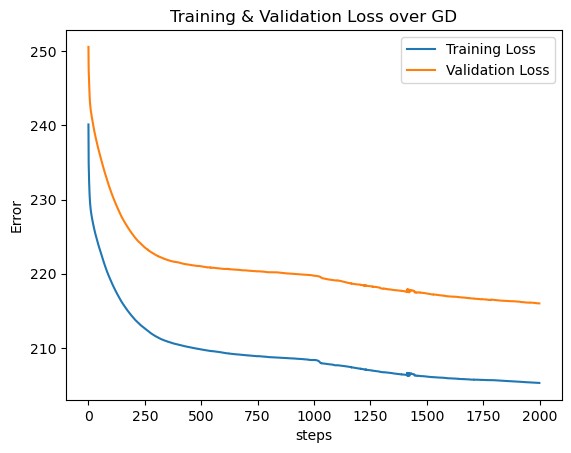

In [31]:
ls_train_loss, ls_val_loss = train_pipeline(X_train, y_train, X_val, y_val, epochs, eta, batch_size=64)

plt.plot(range(epochs), ls_train_loss, label='Training Loss')
plt.plot(range(epochs), ls_val_loss, label='Validation Loss')
plt.title('Training & Validation Loss over GD')
plt.xlabel('steps')
plt.ylabel('Error')
plt.legend()
plt.show()

## Step 5: Test the Model

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
# predict
_, _, _, _, y_pred = f(X_test)
y_pred = y_pred.reshape(-1, 1)

# evaluate accuracy
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R^2: ", r2_score(y_test, y_pred))

MSE:  213.56527493335366
R^2:  0.1297150332424848
